## feature ranking with elimination

In [1]:
import csv
import time  # Just to compare fit times
from pathlib import Path
from pprint import pprint
import csv
import multiprocessing
import distributed
import time

In [2]:
import pandas as pd
import numpy as np


import dask
import dask.array as da
import dask.dataframe as dd
from dask.distributed import Client, wait, LocalCluster


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb

# from dask_cuda import LocalCUDACluster
# from dask_ml.model_selection import train_test_split
# from dask_ml.metrics import r2_score
# import xgboost as xgb
# from matplotlib import pyplot as plt
# from sklearn import metrics
# from sklearn.model_selection import train_test_split
# from tune_sklearn import TuneSearchCV
# from xgboost import XGBRegressor

In [257]:
input_dataset_path = Path('../data/input_dataset_filtered.csv')

## In-house Recursive feature elimination

In [3]:

# from sklearn.metrics import  explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# Start cluster and client. This is currently local, although I would like to make this distributed across many nodes.
# cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES='0,1,2,3', threads_per_worker=2)
cluster = LocalCluster(n_workers=24,threads_per_worker=2,dashboard_address='0.0.0.0:8787')
# cluster = LocalCluster(dashboard_address='0.0.0.0:8787') # Workers: 6, Cores: 24
# cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES='0,1,2,3', threads_per_worker=24,dashboard_address='0.0.0.0:8787')

# cluster = LocalCUDACluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:43439 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 24 Cores: 48 Memory: 134.74 GB


In [15]:
def get_score_without_feature(X, y):
        
        # Feature Matrix    
        now = time.time()
        # Prep Training/Testing Dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, shuffle=False)
        del X
        dtrain = xgb.DMatrix(data=X_train, label=y_train)
        dtest = xgb.DMatrix(data=X_test, label=y_test)

        del X_train
        del X_test
        del y_train

        # XGBoost model
        param = {'objective':'reg:squarederror','tree_method':'gpu_hist'}
        num_round = 50
        xg_reg = xgb.train(param, dtrain, num_round)
        y_pred = xg_reg.predict(dtest)

        del xg_reg
        del dtest
        del dtrain

        
        
        del y_pred
        del y_test
        now = after.time()
        print("Time taken for one training: ", str(after-now))
        return r2_score(y_test, y_pred)
    

In [268]:
def find_least_important_feature(X, y, client):
        
    intermediate_results = {}
    for featureindex,feature_name in enumerate(X.columns):
        score_without_feature = get_score_without_feature(X.drop(feature_name,axis=1), y)
        intermediate_results[feature_name] = score_without_feature
           
    now = time.time()
    # calculate the results        
    lowest_feature = None
    lowest_score = 1
    for feature_name in intermediate_results.keys():
        score_without_feature = intermediate_results[feature_name].compute()
        if score_without_feature <= lowest_score:
            lowest_score = score_without_feature
            lowest_feature = feature_name
        del score_without_feature
    after = time.time()
    print("Time taken for scoring: ", str(after-now))
    del intermediate_results
    return(lowest_score,lowest_feature)
    
    

In [38]:
feature_names = ["target", "LOC_distance_to_coast", "mrvbf_9", "relief_mrvbf_3s_mosaic", "relief_elev_focalrange1000m_3s", "relief_elev_focalrange300m_3s", "saga_wetSM_85_resampled", "tpi_300", "slope_fill2", "dem_fill", "3dem_mag2", "3dem_mag1_fin", "3dem_mag0.fin", "relief_roughness", "LATITUDE_GRID1_clip", "LATITUDE_GRID1_clip", "Dose_2016", "Potassium_2016", "Thorium_2016", "Rad2016U_Th", "Rad2016K_Th", "national_Wii_RF_multirandomforest_prediction", "si_geol1", "ceno_euc_aust1", "Grav_lane_clip", "be-30y-85m-avg-ND-NIR-GREEN.filled.lzw.nodata", "be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata", "be-30y-85m-avg-ND-SWIR1-SWIR2.filled.lzw.nodata", "be-30y-85m-avg_BLUE+SWIR2", "be-30y-85m-avg-ND-SWIR1-NIR.filled.lzw.nodata", "be-30y-85m-avg-CLAY-PC2.filled.lzw.nodata", "be-30y-85m-avg-ND-RED-BLUE.filled.lzw.nodata", "be-30y-85m-avg-RED.filled.lzw.nodata", "be-30y-85m-avg-GREEN.filled.lzw.nodata", "be-l8-all-85m-avg-BLUE.filled.lzw.nodata", "be-l8-all-85m-avg-NIR.filled.lzw.nodata", "be-30y-85m-avg-SWIR1.filled.lzw.nodata", "be-30y-85m-avg-SWIR2.filled.lzw.nodata", "s2-dpca-85m", "water-85m", "clim_EPA_albers", "Clim_Prescott_LindaGregory", "clim_PTA_albers", "clim_WDA_albers", "clim_RSM_albers"]
print(len(feature_names))
myset = set(feature_names)
print(len(myset))

45
43


In [36]:
from sklearn.model_selection import train_test_split

dtrain = xgb.DMatrix('../data/input_dataset_filtered_renamed.csv?format=csv&label_column=0',nthread=-1,feature_names=feature_names)



ValueError: feature_names must be unique

In [33]:
dtrain.iloc[0]

AttributeError: 'DMatrix' object has no attribute 'iloc'

In [30]:
dtrain.get_label()

array([0.      , 0.012695, 0.004673, ..., 0.028176, 0.010419, 0.027754],
      dtype=float32)

In [ ]:
dtrain.save_binary('train.buffer')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [4]:
dtrain = xgb.DMatrix('train.buffer')

In [5]:
dtrain

In [7]:
param = {'objective':'reg:squarederror','tree_method':'gpu_hist'}
num_round = 10

In [8]:
bst = xgb.train(param, dtrain, num_round)

In [10]:
ypred = bst.predict(dtrain)

In [16]:
r2_score(y_test, y_pred)

NameError: name 'y_test' is not defined

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

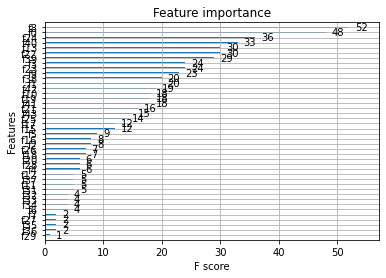

In [11]:
xgb.plot_importance(bst)

<AxesSubplot:>

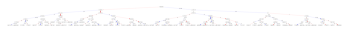

In [12]:
xgb.plot_tree(bst, num_trees=2)

In [14]:
#xgb.to_graphviz(bst, num_trees=2)

In [269]:
%%time

df = dd.read_csv('')
X = df.drop("target",axis=1)   # Feature Matrix
y = df["target"]               # Target Variable

min_features_required = 43
complete_result = {}
results = []

current_total_feature = X.shape[1]
complete_result[current_total_feature] = {}

lowest_score,lowest_feature = find_least_important_feature(X,y,client)
lowest_score,lowest_feature
results.append((lowest_score,lowest_feature))
print(lowest_score,lowest_feature)

# current_X = X.drop(lowest_feature,axis=1)   
# current_total_feature = X.shape[1]

# while(current_total_feature>min_features_required):

#     lowest_score,lowest_feature = find_least_important_feature(current_X,y,client)
#     results.append((lowest_score,lowest_feature))
#     current_X = current_X.drop(lowest_feature,axis=1)
#     current_total_feature = current_X.shape[1]
#     print(lowest_score,lowest_feature)



NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

In [126]:
results

[]

In [ ]:
#save results
import pickle

fileObj = open('complete_result_irfec.pkl', 'wb')
pickle.dump(complete_result,fileObj)
fileObj.close()

In [ ]:
## In-house Recursive feature elimination


## Shutdown Cluster

In [264]:
client = distributed.client._get_global_client()
client

Client Scheduler: tcp://127.0.0.1:44195 Dashboard: http://127.0.0.1:37873/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [265]:
client.shutdown()


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
